In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Accuracy, Recall, F1Score
from tensorflow.keras.losses import Poisson
from tensorflow.keras.optimizers import Adam
from keras.utils import get_custom_objects
import tensorflow as tf
from keras import backend as K
import pandas as pd



In [29]:

def custom_loss_function(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)  # Convert y_true to float32
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    win_horse = y_true[:, 0:1]
    win_odds = y_true[:, 1:2]
    gain_loss_vector = K.concatenate([win_horse * (win_odds - 1) + (1 - win_horse) * -1,
    K.zeros_like(win_odds)], axis=1)
    return -0.1 * K.mean(K.sum(gain_loss_vector * y_pred, axis=1))
    #return -1 * tf.reduce_mean(tf.reduce_sum(gain_loss_vector * y_pred, axis=1))

get_custom_objects().update({"custom_loss_function": custom_loss_function})

In [30]:
NN1 = Sequential()
NN1.add(InputLayer(input_shape=(6, ))) # input layer
NN1.add(Dense(32, activation='relu')) # hidden layer 1
NN1.add(Dense(2, activation='softmax')) # output layer

In [31]:
NN1.load_weights("../Models/JS_weights/custom_scorer1")

In [32]:
X_test = pd.read_csv("../JS_notebooks/NN1_X_test.csv")

In [33]:
y_test = pd.read_csv("../JS_notebooks/NN1_y_test.csv")

In [34]:
backtest_test = pd.read_csv("../JS_notebooks/NN1_backtest_test.csv")

In [35]:
y_pred = NN1.predict(X_test)

1028/1028 [==============================] - 0s 277us/step


<Axes: ylabel='Count'>

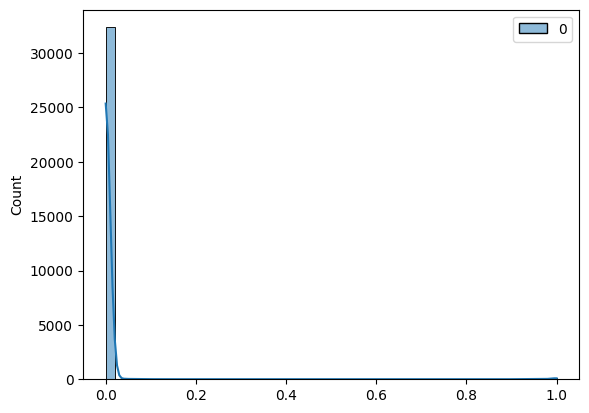

In [36]:
import seaborn as sns
sns.histplot(y_pred[:, 0:1], bins = 50, kde=True)

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_34617/2240373710.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['cumulative_profit'] = df0['linear_target'].cumsum()
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_34617/2240373710.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['cumulative_profit'] = df5['linear_target'].cumsum()
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_34617/2240373710.py:38: SettingWithCopyWarning: 
A value is trying to be set on a

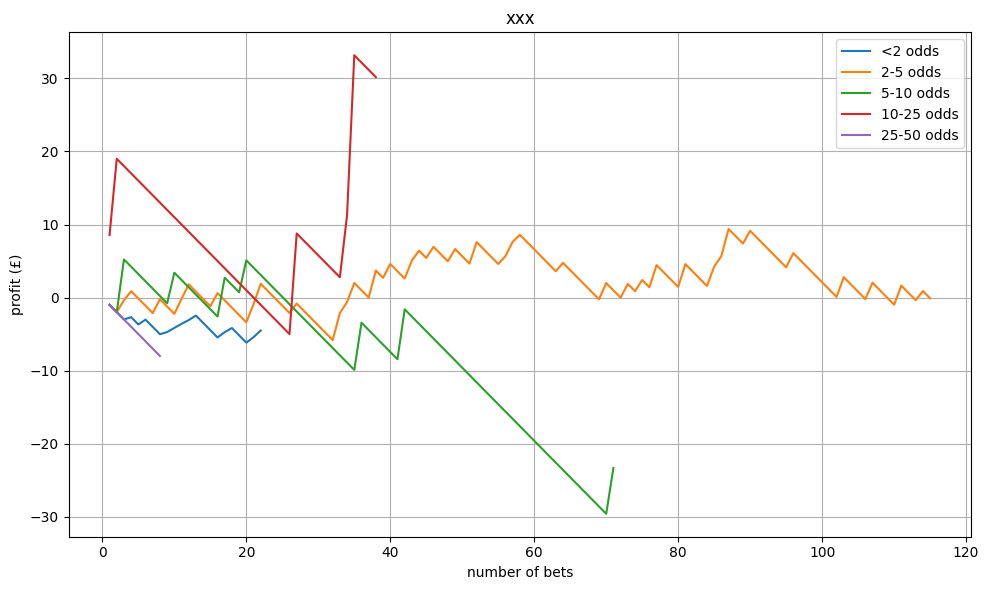

In [37]:
backtest_test['model_preds'] = y_pred[:, 0:1]
backtest_test['odds_preds'] = 1/ backtest_test['f_pm_01m']
backtest_test['model_edge_basic'] = backtest_test['model_preds'] - backtest_test['odds_preds']
backtest_test['model_edge_proportionate'] = backtest_test['model_preds'] / backtest_test['odds_preds']
#backtest_test = backtest_test.drop(columns=['f_ko'])
model_preds_race = backtest_test.groupby('f_id').sum().reset_index()
model_preds_race2 = model_preds_race[['f_id', 'model_preds', 'odds_preds']]
dict_odds_preds = model_preds_race2.set_index('f_id')['odds_preds'].to_dict()
dict_race_preds = model_preds_race2.set_index('f_id')['model_preds'].to_dict()
backtest_test['race_model_preds'] = backtest_test['f_id'].map(dict_race_preds)
backtest_test['race_odds_preds'] = backtest_test['f_id'].map(dict_odds_preds)
backtest_test['model_preds_scaled'] = (backtest_test['model_preds'] / backtest_test['race_model_preds']) * backtest_test['race_odds_preds']
backtest_test['model_edge_basic_scaled'] = backtest_test['model_preds_scaled'] - backtest_test['odds_preds']
backtest_test['model_edge_prop_scaled'] = backtest_test['model_preds_scaled'] / backtest_test['odds_preds']
backtest_test['model_preds'] = round(backtest_test['model_preds'],2)
# Create dataframes of horses above specific proba_difference thresholds

all_bets = backtest_test
above0 = backtest_test[(backtest_test['model_preds'] >= 0.5) & (backtest_test['f_pm_01m'] < 2)]
above5 = backtest_test[(backtest_test['model_preds'] >= 0.5) & (backtest_test['f_pm_01m'] >= 2) & (backtest_test['f_pm_01m'] < 5)]
above10 = backtest_test[(backtest_test['model_preds'] >= 0.5) & (backtest_test['f_pm_01m'] >= 5) & (backtest_test['f_pm_01m'] < 10)]
above15 = backtest_test[(backtest_test['model_preds'] >= 0.5) & (backtest_test['f_pm_01m'] >= 10) & (backtest_test['f_pm_01m'] < 25)]
above20 = backtest_test[(backtest_test['model_preds'] >= 0.5) & (backtest_test['f_pm_01m'] >= 25) & (backtest_test['f_pm_01m'] < 51)]
above30 = backtest_test[backtest_test['model_preds'] >= 0.5]

# Calculate evolutions of profits for each threshold

dfall = all_bets
dfall['cumulative_profit'] = dfall['linear_target'].cumsum()

df0 = above0
df0['cumulative_profit'] = df0['linear_target'].cumsum()

df5 = above5
df5['cumulative_profit'] = df5['linear_target'].cumsum()

df10 = above10
df10['cumulative_profit'] = df10['linear_target'].cumsum()

df15 = above15
df15['cumulative_profit'] = df15['linear_target'].cumsum()

df20 = above20
df20['cumulative_profit'] = df20['linear_target'].cumsum()

df30 = above30
df30['cumulative_profit'] = df30['linear_target'].cumsum()

import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(10,6))
#plt.plot(range(1, len(dfall) + 1), dfall['cumulative_profit'], label='all bets')
plt.plot(range(1, len(df0) + 1), df0['cumulative_profit'], label='<2 odds')
plt.plot(range(1, len(df5) + 1), df5['cumulative_profit'], label='2-5 odds')
plt.plot(range(1, len(df10) + 1), df10['cumulative_profit'], label='5-10 odds')
plt.plot(range(1, len(df15) + 1), df15['cumulative_profit'], label='10-25 odds')
plt.plot(range(1, len(df20) + 1), df20['cumulative_profit'], label='25-50 odds')
#plt.plot(range(1, len(df30) + 1), df30['cumulative_profit'], label='0.875 threshold')

plt.title("xxx")
plt.xlabel("number of bets")
plt.ylabel("profit (£)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [32]:
NN2 = Sequential()
NN2.add(InputLayer(input_shape=(7, ))) # input layer
NN2.add(Dense(32, activation='relu')) # hidden layer 1
NN2.add(Dense(2, activation='softmax')) # output layer

In [33]:
NN2.load_weights("../Models/JS_weights/custom_scorer0.05_7input_l16")

In [34]:
X_test2 = pd.read_csv("../JS_notebooks/NN2_X_test_7.csv")
y_test2 = pd.read_csv("../JS_notebooks/NN2_y_test_7.csv")
backtest_test2 = pd.read_csv("../JS_notebooks/NN2_backtest_test_7.csv")

1028/1028 [==============================] - 0s 231us/step


<Axes: ylabel='Count'>

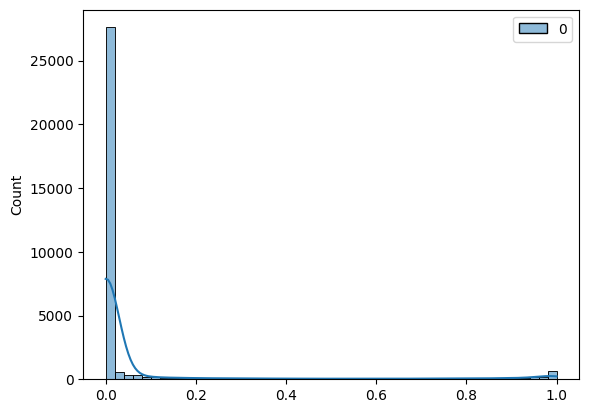

In [36]:
y_pred = NN2.predict(X_test2)
import seaborn as sns
sns.histplot(y_pred[:, 0:1], bins = 50, kde=True)

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_32560/2240373710.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['cumulative_profit'] = df5['linear_target'].cumsum()
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_32560/2240373710.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df10['cumulative_profit'] = df10['linear_target'].cumsum()
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_32560/2240373710.py:41: SettingWithCopyWarning: 
A value is trying to be set on

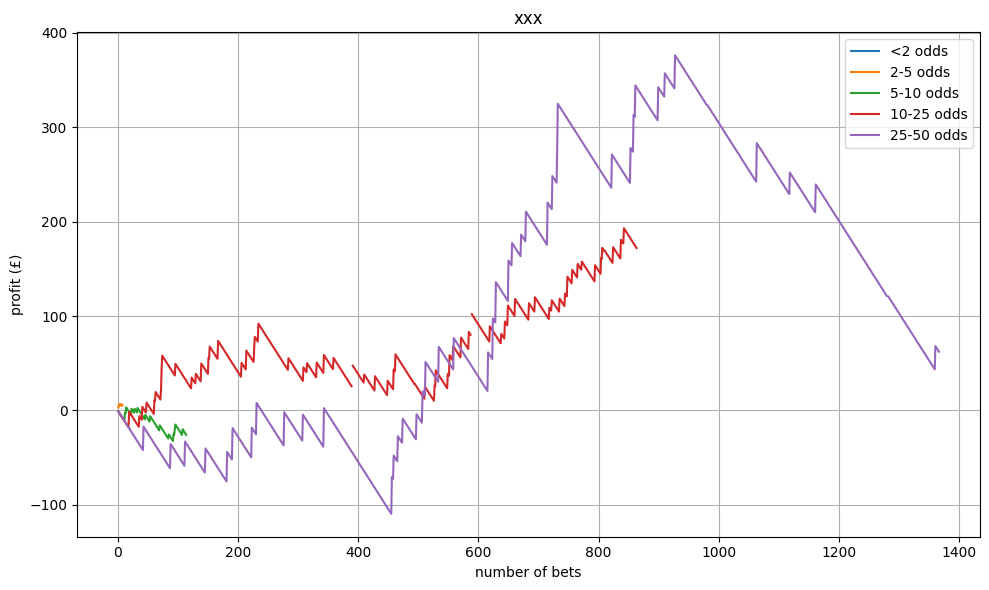

In [37]:
backtest_test['model_preds'] = y_pred[:, 0:1]
backtest_test['odds_preds'] = 1/ backtest_test['f_pm_01m']
backtest_test['model_edge_basic'] = backtest_test['model_preds'] - backtest_test['odds_preds']
backtest_test['model_edge_proportionate'] = backtest_test['model_preds'] / backtest_test['odds_preds']
#backtest_test = backtest_test.drop(columns=['f_ko'])
model_preds_race = backtest_test.groupby('f_id').sum().reset_index()
model_preds_race2 = model_preds_race[['f_id', 'model_preds', 'odds_preds']]
dict_odds_preds = model_preds_race2.set_index('f_id')['odds_preds'].to_dict()
dict_race_preds = model_preds_race2.set_index('f_id')['model_preds'].to_dict()
backtest_test['race_model_preds'] = backtest_test['f_id'].map(dict_race_preds)
backtest_test['race_odds_preds'] = backtest_test['f_id'].map(dict_odds_preds)
backtest_test['model_preds_scaled'] = (backtest_test['model_preds'] / backtest_test['race_model_preds']) * backtest_test['race_odds_preds']
backtest_test['model_edge_basic_scaled'] = backtest_test['model_preds_scaled'] - backtest_test['odds_preds']
backtest_test['model_edge_prop_scaled'] = backtest_test['model_preds_scaled'] / backtest_test['odds_preds']
backtest_test['model_preds'] = round(backtest_test['model_preds'],2)
# Create dataframes of horses above specific proba_difference thresholds

all_bets = backtest_test
above0 = backtest_test[(backtest_test['model_preds'] >= 0.5) & (backtest_test['f_pm_01m'] < 2)]
above5 = backtest_test[(backtest_test['model_preds'] >= 0.5) & (backtest_test['f_pm_01m'] >= 2) & (backtest_test['f_pm_01m'] < 5)]
above10 = backtest_test[(backtest_test['model_preds'] >= 0.5) & (backtest_test['f_pm_01m'] >= 5) & (backtest_test['f_pm_01m'] < 10)]
above15 = backtest_test[(backtest_test['model_preds'] >= 0.5) & (backtest_test['f_pm_01m'] >= 10) & (backtest_test['f_pm_01m'] < 25)]
above20 = backtest_test[(backtest_test['model_preds'] >= 0.5) & (backtest_test['f_pm_01m'] >= 25) & (backtest_test['f_pm_01m'] < 51)]
above30 = backtest_test[backtest_test['model_preds'] >= 0.5]

# Calculate evolutions of profits for each threshold

dfall = all_bets
dfall['cumulative_profit'] = dfall['linear_target'].cumsum()

df0 = above0
df0['cumulative_profit'] = df0['linear_target'].cumsum()

df5 = above5
df5['cumulative_profit'] = df5['linear_target'].cumsum()

df10 = above10
df10['cumulative_profit'] = df10['linear_target'].cumsum()

df15 = above15
df15['cumulative_profit'] = df15['linear_target'].cumsum()

df20 = above20
df20['cumulative_profit'] = df20['linear_target'].cumsum()

df30 = above30
df30['cumulative_profit'] = df30['linear_target'].cumsum()

import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(10,6))
#plt.plot(range(1, len(dfall) + 1), dfall['cumulative_profit'], label='all bets')
plt.plot(range(1, len(df0) + 1), df0['cumulative_profit'], label='<2 odds')
plt.plot(range(1, len(df5) + 1), df5['cumulative_profit'], label='2-5 odds')
plt.plot(range(1, len(df10) + 1), df10['cumulative_profit'], label='5-10 odds')
plt.plot(range(1, len(df15) + 1), df15['cumulative_profit'], label='10-25 odds')
plt.plot(range(1, len(df20) + 1), df20['cumulative_profit'], label='25-50 odds')
#plt.plot(range(1, len(df30) + 1), df30['cumulative_profit'], label='0.875 threshold')

plt.title("xxx")
plt.xlabel("number of bets")
plt.ylabel("profit (£)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
NN3 = Sequential()
NN3.add(InputLayer(input_shape=(7, ))) # input layer
NN3.add(Dense(32, activation='relu')) # hidden layer 1
NN3.add(Dense(2, activation='softmax')) # output layer

In [39]:
NN3.load_weights("../Models/JS_weights/custom_scorer0.1_7input_l16")

1028/1028 [==============================] - 0s 233us/step


<Axes: ylabel='Count'>

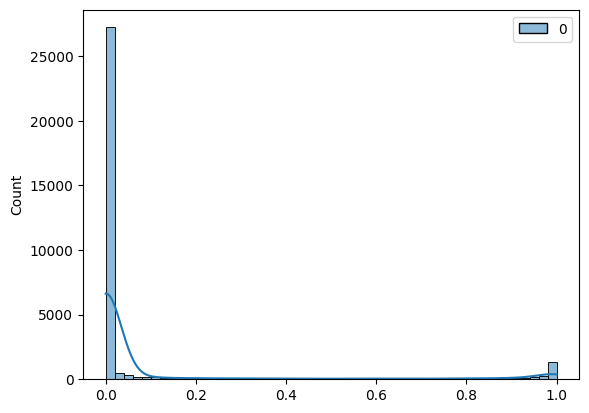

In [40]:
y_pred = NN3.predict(X_test2)
import seaborn as sns
sns.histplot(y_pred[:, 0:1], bins = 50, kde=True)

/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_32560/2240373710.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['cumulative_profit'] = df5['linear_target'].cumsum()
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_32560/2240373710.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df10['cumulative_profit'] = df10['linear_target'].cumsum()
/var/folders/w6/wdkqbmf17b90n_r35p0cb7x00000gn/T/ipykernel_32560/2240373710.py:41: SettingWithCopyWarning: 
A value is trying to be set on

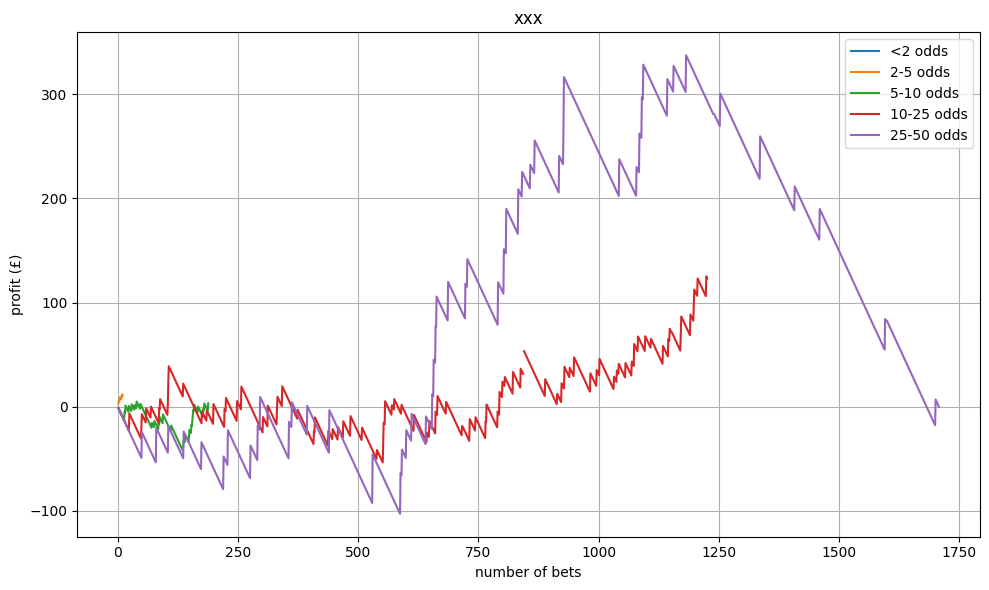

In [41]:
backtest_test['model_preds'] = y_pred[:, 0:1]
backtest_test['odds_preds'] = 1/ backtest_test['f_pm_01m']
backtest_test['model_edge_basic'] = backtest_test['model_preds'] - backtest_test['odds_preds']
backtest_test['model_edge_proportionate'] = backtest_test['model_preds'] / backtest_test['odds_preds']
#backtest_test = backtest_test.drop(columns=['f_ko'])
model_preds_race = backtest_test.groupby('f_id').sum().reset_index()
model_preds_race2 = model_preds_race[['f_id', 'model_preds', 'odds_preds']]
dict_odds_preds = model_preds_race2.set_index('f_id')['odds_preds'].to_dict()
dict_race_preds = model_preds_race2.set_index('f_id')['model_preds'].to_dict()
backtest_test['race_model_preds'] = backtest_test['f_id'].map(dict_race_preds)
backtest_test['race_odds_preds'] = backtest_test['f_id'].map(dict_odds_preds)
backtest_test['model_preds_scaled'] = (backtest_test['model_preds'] / backtest_test['race_model_preds']) * backtest_test['race_odds_preds']
backtest_test['model_edge_basic_scaled'] = backtest_test['model_preds_scaled'] - backtest_test['odds_preds']
backtest_test['model_edge_prop_scaled'] = backtest_test['model_preds_scaled'] / backtest_test['odds_preds']
backtest_test['model_preds'] = round(backtest_test['model_preds'],2)
# Create dataframes of horses above specific proba_difference thresholds

all_bets = backtest_test
above0 = backtest_test[(backtest_test['model_preds'] >= 0.5) & (backtest_test['f_pm_01m'] < 2)]
above5 = backtest_test[(backtest_test['model_preds'] >= 0.5) & (backtest_test['f_pm_01m'] >= 2) & (backtest_test['f_pm_01m'] < 5)]
above10 = backtest_test[(backtest_test['model_preds'] >= 0.5) & (backtest_test['f_pm_01m'] >= 5) & (backtest_test['f_pm_01m'] < 10)]
above15 = backtest_test[(backtest_test['model_preds'] >= 0.5) & (backtest_test['f_pm_01m'] >= 10) & (backtest_test['f_pm_01m'] < 25)]
above20 = backtest_test[(backtest_test['model_preds'] >= 0.5) & (backtest_test['f_pm_01m'] >= 25) & (backtest_test['f_pm_01m'] < 51)]
above30 = backtest_test[backtest_test['model_preds'] >= 0.5]

# Calculate evolutions of profits for each threshold

dfall = all_bets
dfall['cumulative_profit'] = dfall['linear_target'].cumsum()

df0 = above0
df0['cumulative_profit'] = df0['linear_target'].cumsum()

df5 = above5
df5['cumulative_profit'] = df5['linear_target'].cumsum()

df10 = above10
df10['cumulative_profit'] = df10['linear_target'].cumsum()

df15 = above15
df15['cumulative_profit'] = df15['linear_target'].cumsum()

df20 = above20
df20['cumulative_profit'] = df20['linear_target'].cumsum()

df30 = above30
df30['cumulative_profit'] = df30['linear_target'].cumsum()

import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(10,6))
#plt.plot(range(1, len(dfall) + 1), dfall['cumulative_profit'], label='all bets')
plt.plot(range(1, len(df0) + 1), df0['cumulative_profit'], label='<2 odds')
plt.plot(range(1, len(df5) + 1), df5['cumulative_profit'], label='2-5 odds')
plt.plot(range(1, len(df10) + 1), df10['cumulative_profit'], label='5-10 odds')
plt.plot(range(1, len(df15) + 1), df15['cumulative_profit'], label='10-25 odds')
plt.plot(range(1, len(df20) + 1), df20['cumulative_profit'], label='25-50 odds')
#plt.plot(range(1, len(df30) + 1), df30['cumulative_profit'], label='0.875 threshold')

plt.title("xxx")
plt.xlabel("number of bets")
plt.ylabel("profit (£)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()